## Taller 01 Kagle
##### Mary Yuliana Jaramillo - github.com/maryyuliana
##### Juan Fernando Gómez - github.com/HanisDad95

#### 1. Importar paquetes

In [1]:
import pandas as pd
import numpy as np
import scipy
pd.set_option('display.max_columns',None)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from numpy.random import randint
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.impute import *
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.svm import SVC
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu

#### 2. Análsis Exploratorio de Datos

##### Cargue de datos

In [64]:
url = "https://github.com/HanisDad95/FundAnalitica2_2024_1/raw/master/df_train.parquet"

In [65]:
full_data= pd.read_parquet(url)
full_data.head(2)

,GENERO,ESTADO_CIVIL,FECHA_NACIMIENTO,CODIGO_SEDE,MULTI_CANCER,CESION,RIESGOS,CANCER_MAMA_FAMILIAR,CANCER_OTRO_SITIO,CANCER_OTRO_SITIO_FAMILIAR,CEREBRAL_FAMILIAR,FECHA_DATOS_PESO_TALLA,PESO,TALLA,FECHA_CONSULTA_TENSION,TSISTOLICA,TDIASTOLICA,Fecha_cero,Target,mes_6,mes_5,mes_4,mes_3,mes_2,mes_1,valor_servicio,IV_NIVEL,HOSPI_NO_QUIRURGICA,URGENCIAS,HOSPITALIZACION,CITA_ONCOLOGICA,Biopsias_cancer,radioterapias_cancer,quimioterapias__cancer,hormonoterapias__cancer,cuidado_palitiavo__cancer,inmunoterapias_cancer,Citas_oncologicas_cancer,psiquiatria_cancer,psicologia_cancer,nutricion_cancer,atencion_nutricion
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987,F,SO,1977-01-17,1051,None,0,2.0,0,0,1,0,2023-03-02,52.0,149.0,2023-03-02,112.0,70.0,2023-03-01,0.0,51060.0,29220.0,303680.0,0.0,33140.0,36940.0,454040.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,Sin servicios nutricion
3423,F,CA,1980-10-13,1028,None,0,1.0,0,0,0,0,2023-03-13,67.0,163.0,2022-09-08,120.0,80.0,2023-03-01,0.0,544460.0,518002.0,4800.0,122815.0,0.0,0.0,1190077.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,1.0,0.0,Sin servicios nutricion


##### Análisis de datos faltantes

In [66]:
full_data = pd.DataFrame(full_data)

In [67]:
full_data.dtypes

GENERO                                object
ESTADO_CIVIL                          object
FECHA_NACIMIENTO              datetime64[us]
CODIGO_SEDE                           object
MULTI_CANCER                          object
CESION                                object
RIESGOS                              float64
CANCER_MAMA_FAMILIAR                  object
CANCER_OTRO_SITIO                     object
CANCER_OTRO_SITIO_FAMILIAR            object
CEREBRAL_FAMILIAR                     object
FECHA_DATOS_PESO_TALLA        datetime64[us]
PESO                                 float64
TALLA                                float64
FECHA_CONSULTA_TENSION        datetime64[us]
TSISTOLICA                           float64
TDIASTOLICA                          float64
Fecha_cero                    datetime64[us]
Target                               float64
mes_6                                float64
mes_5                                float64
mes_4                                float64
mes_3     

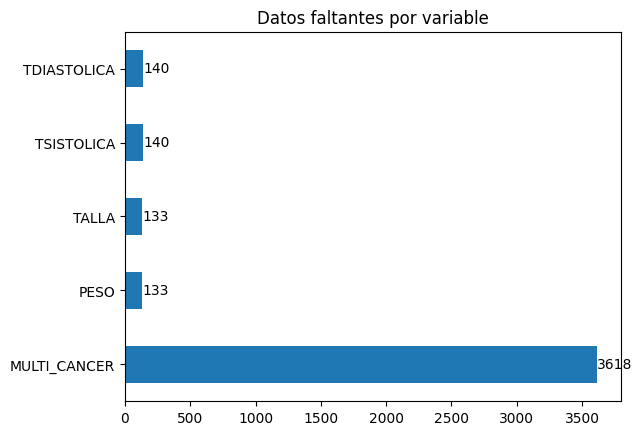

In [68]:
ax = full_data.loc[:,full_data.columns[full_data.isna().sum() > 0]].isna().sum().plot(kind = 'barh')
ax.bar_label(ax.containers[0])
plt.title('Datos faltantes por variable')
plt.show()

In [69]:
for i, j in full_data.isna().sum(axis = 1).value_counts().items():
    match i:
        case 0: 
            print(f'En el dataset hay {j} observaciones sin datos nulos.')   
        case _:
            print(f'En el dataset hay {j} observaciones con datos nulos o faltantes en {i} de sus variables.')

En el dataset hay 3477 observaciones con datos nulos o faltantes en 1 de sus variables.
En el dataset hay 327 observaciones sin datos nulos.
En el dataset hay 118 observaciones con datos nulos o faltantes en 5 de sus variables.
En el dataset hay 23 observaciones con datos nulos o faltantes en 3 de sus variables.
En el dataset hay 6 observaciones con datos nulos o faltantes en 2 de sus variables.
En el dataset hay 4 observaciones con datos nulos o faltantes en 4 de sus variables.


##### Creación de nuevas variables




Se crea variables a partir de las variables originales del data set, que puedan aportar al análisis tales como
IMC = índice de masa coporal 
SumCosto = Sumatoria de los costos en los meses 1 a 6 antes de la fecha cero
EdadComplicacion = Edad al momento de la complicación

Se eliminan variables que no son relevantes para el análisis 'Fecha_Cero','CODIGO_SEDE'

In [70]:
### Definición de nuevas variables
class FeatureTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Perform arbitary transformation
        X['IMC'] = X['PESO']/X['TALLA'] ### HACER UNA MEJOR CONSTRUCCIÓN DE ESTA VARIABLE QUE TOME EN CUENTA LA EDAD
        X['SumCosto'] = X.loc[:,['mes_6', 'mes_5', 'mes_4', 'mes_3', 'mes_2', 'mes_1',]].agg(sum, axis = 1) ### 
        X['EdadComplicacion'] = (((X['Fecha_cero'] - X['FECHA_NACIMIENTO']).dt.components.days)/365).astype(int)
        X['MULTI_CANCER'] = X['MULTI_CANCER'].fillna(0)
        X['Target'] = X['Target'].astype('int')
        
        var_eliminar = ['Fecha_cero','CODIGO_SEDE']
        X.drop(columns = var_eliminar, axis = 1, inplace = True) ## IMPORTANTE ESTE PASO PARA QUE NO VAYAMOS A DEJAR ESTA VARIABLE
        return X

In [71]:
# Pipeline creación nuevas variables
pipeline_var_nuevas = Pipeline([('feature_transformer', FeatureTransformer())])

In [72]:
full_data2 = pipeline_var_nuevas.transform(full_data)

C:\Users\yulia\AppData\Local\Temp\ipykernel_5636\2618472343.py:9: FutureWarning: The provided callable <built-in function sum> is currently using DataFrame.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  X['SumCosto'] = X.loc[:,['mes_6', 'mes_5', 'mes_4', 'mes_3', 'mes_2', 'mes_1',]].agg(sum, axis = 1) ###


In [73]:
## Se crea el nuevo dataframe con la
full_data2 = pd.DataFrame(full_data2)

##### Preprocesamiento del data set
Se realiza una identificación de las variables númericas y categóricas para el análisis

In [74]:
## Se define una función para obtener el índice de las variables categóricas, numéricas y variable objetivo
def SepararNumCate(df : pd.DataFrame, target_variable : str):
    '''Returns a triplet with column names (numerical, categorical, target)
    '''
    numerical = df.select_dtypes(include = 'number').columns.to_list()
    date_time = df.select_dtypes(include = 'datetime').columns.to_list()
    categorical = df.select_dtypes(include = 'object').columns.to_list()
    numerical.remove(target_variable) ## REMOVES THE TARGET VARIABLE
    target = df[target_variable].copy()
    return numerical, date_time, categorical, target


num_idx, date_time_idx, categ_idx, target_idx = SepararNumCate(full_data2,'Target')

In [75]:
## Crear los data frames con cada uno de los tipos de variables para el análisis descriptivo
var_cat = full_data2[categ_idx]
var_num = full_data2[num_idx]
target_idx = pd.DataFrame(target_idx)

In [76]:
# Se crea una data entre la variables categoricas y la variable objetivo
data_cat = pd.concat([target_idx, var_cat], axis=1)

In [77]:
def graficos_cat(data, var_target):
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(5, 2, figsize=(18, 12), sharey=True)
    
      # Definir mapeo de reclasificación
    mapeo_reclasificacion = {'0': 'No presentó complicaciones', '1': 'Presentó complicaciones'}

    # Reclasificar valores de la variable objetivo
    data[var_target] = data[var_target].replace(mapeo_reclasificacion)

    for i, variable in enumerate(data.columns):  
        if variable != var_target:  
            pd.crosstab(data[var_target], data[variable], normalize='index').plot(kind='bar', ax=eval(f'ax{i+1}'), edgecolor='black', colormap='vlag')
            eval(f'ax{i+1}').get_yaxis().set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
            eval(f'ax{i+1}').tick_params(axis='x', rotation=0)
            eval(f'ax{i+1}').legend(loc='upper left', title=variable)
            eval(f'ax{i+1}').set_xlabel(None)
        else:
            data[var_target].value_counts(normalize=True).sort_index().plot(kind='bar', ax=eval(f'ax{i+1}'), colormap='vlag')
            eval(f'ax{i+1}').get_yaxis().set_visible(False)
            labels = ((data[var_target].value_counts(normalize=True).sort_index()) * 100).round(1).astype('str') + '%'
            eval(f'ax{i+1}').tick_params(axis='x', rotation=0)
            eval(f'ax{i+1}').set_title("Categorías variable dependiente, Train set")
            for container in eval(f'ax{i+1}').containers:
                eval(f'ax{i+1}').bar_label(container, labels=labels)

    plt.tight_layout()  
    plt.show()

##### Análisis de las variables categóricas

La variable dependiente *Target*, se encuentra altamente desbalanceada dentro del data set, el 88.7% representa los pacientes que no tuvieron complicaciones y un 11.3% los pacientes que si presentaron complicaciones. 
Gráficamente se representan cada una de las variables categóricas frente a la variable *target*, no se observa que hayan diferencias significativas entre cada una de las categórias de las variables y las condiciones de 0 = No presentó complicación y 1 = Presentoó complicación. Por lo cual, con el test de contigencia Chi-cuadrado, se confirma que no exise una asoción fuerte entre las variables independientes categóricas y la variable *Target* 


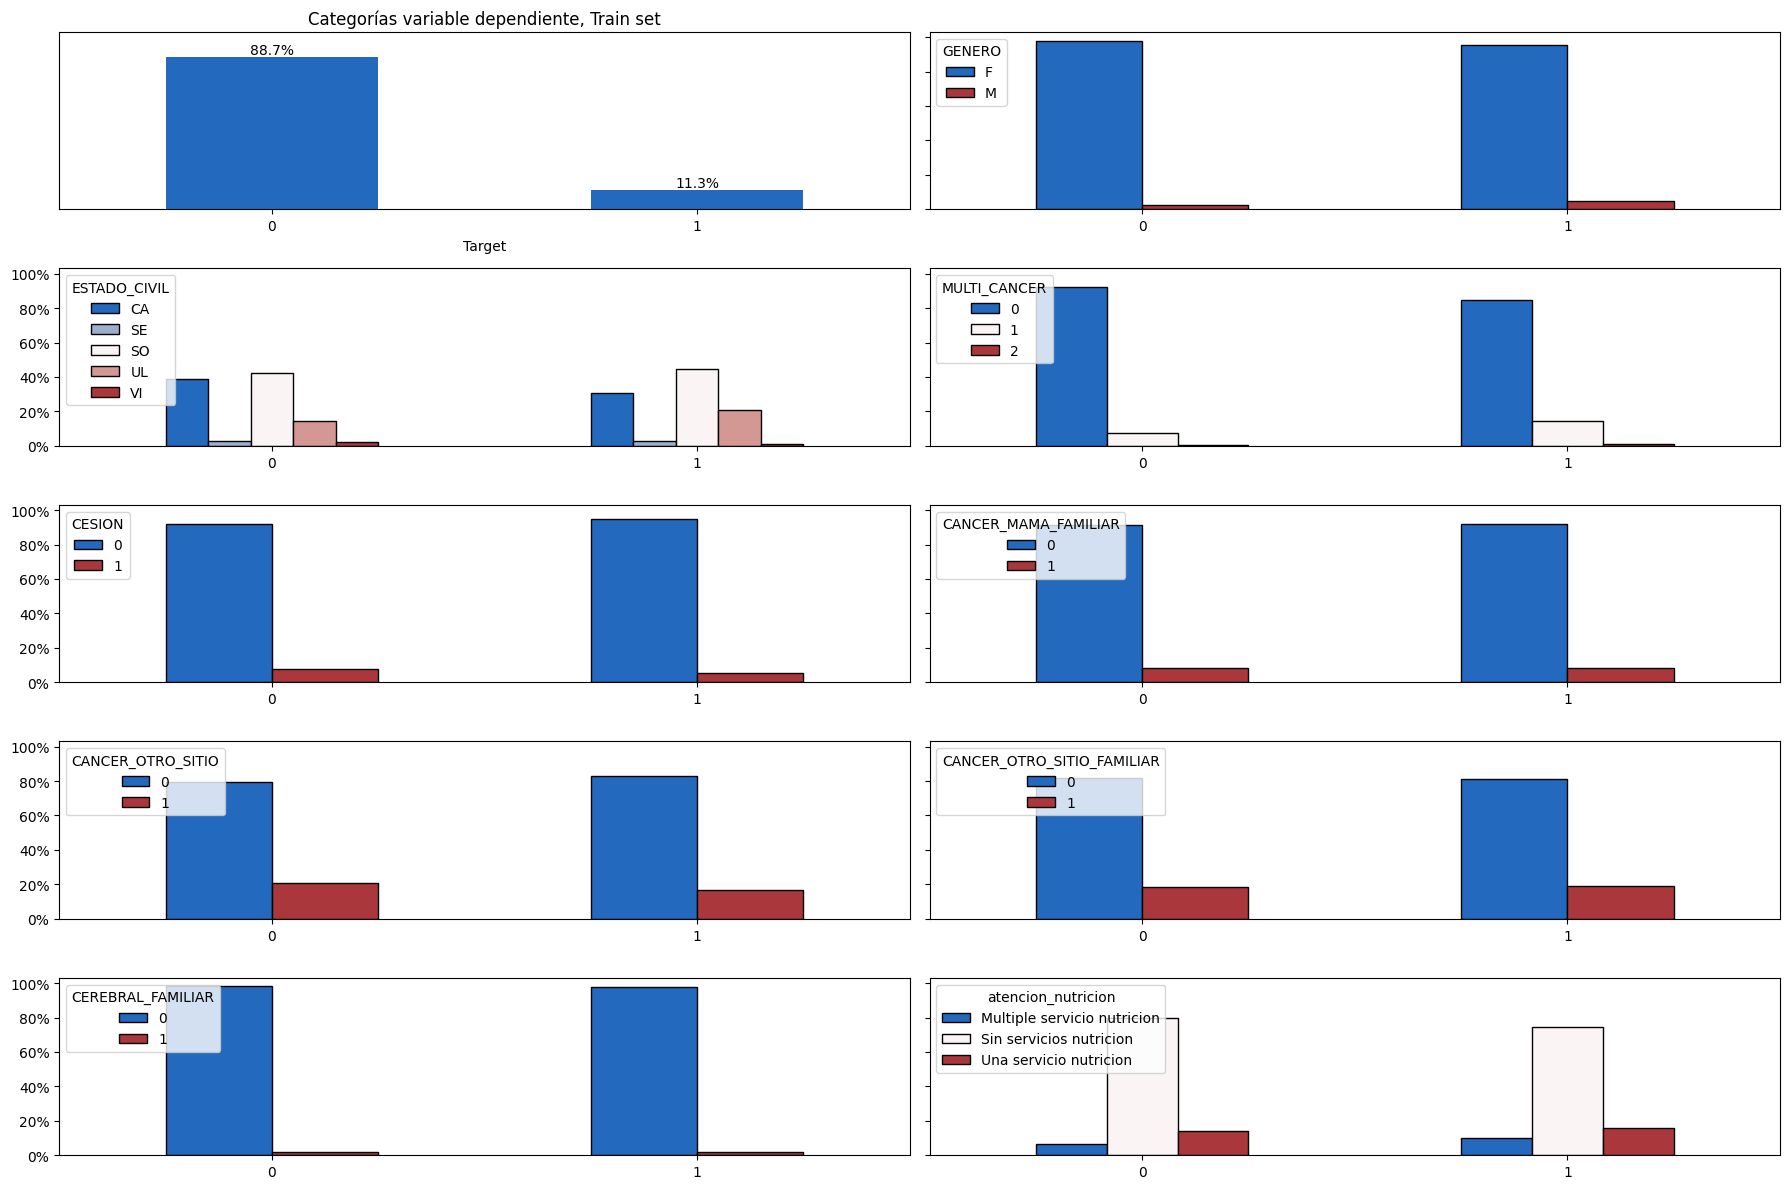

In [78]:
g1 = graficos_cat(data_cat,'Target')

In [80]:
# Función coeficiente de contigencia
def calcular_coeficiente_contingencia(df: pd.DataFrame, cols: list, target_col: str) -> pd.DataFrame:
    resultados = []
    for col in cols:
        tabla_contingencia = pd.crosstab(df[col], df[target_col])
        chi2, p, dof, expected = chi2_contingency(tabla_contingencia)
        n = tabla_contingencia.values.sum()
        coef_contingencia = np.sqrt(chi2 / (n * min(len(tabla_contingencia.index) - 1, len(tabla_contingencia.columns) - 1)))
        resultados.append([col, coef_contingencia])
    df_resultado = pd.DataFrame(resultados, columns=['Variable', 'Coeficiente de Contingencia'])
    df_resultado.sort_values(by='Coeficiente de Contingencia', ascending=False, inplace=True)
    df_resultado.reset_index(drop=True, inplace=True)
    return df_resultado.round(4)

In [81]:
calcular_coeficiente_contingencia(data_cat,categ_idx, 'Target')

,Variable,Coeficiente de Contingencia
0,MULTI_CANCER,0.0884
1,ESTADO_CIVIL,0.0747
2,atencion_nutricion,0.0500
3,GENERO,0.0414
4,CESION,0.0320
5,CANCER_OTRO_SITIO,0.0268
6,CANCER_OTRO_SITIO_FAMILIAR,0.0020
7,CEREBRAL_FAMILIAR,0.0015
8,CANCER_MAMA_FAMILIAR,0.0004


##### Análisis de variables númericas
Para comparar si existen diferencias en las variables nuúmericas para los pacientes que presentaron complicaciones y los que no, se emplea la prueba no párametrica de Wilcoxon-Mann-Whitney. 

Las variables que presentan una mediana significativamente diferente entre los dos grupos son: *valor_servicio, IV_NIVEL, HOSPI_NO_QUIRURGICA,URGENCIAS, HOSPITALIZACION, CITA_ONCOLOGICA, Biopsias_cancer, radioterapias_cancer, quimioterapias__cancer, hormonoterapias__cancer,cuidado_palitiavo__cancer, Citas_oncologicas_cancer, psicologia_cancer, nutricion_cancer, SumCosto, EdadComplicacion*


In [95]:
df_num = pd.concat([target_idx,var_num], axis=1)
cols_eliminar = ['mes_6', 'mes_5', 'mes_4', 'mes_3', 'mes_2', 'mes_1'] 
df_num =df_num.drop(cols_eliminar,axis=1)

In [97]:
def calcular_prueba_medianas(df: pd.DataFrame, cols: list, target_col: str) -> pd.DataFrame:
    resultados = []
   
    for col in cols:
        # Eliminar filas con valores nulos en la columna actual y la columna objetivo
        df_sin_nulos = df.dropna(subset=[col, target_col])

        # Dividir los datos en dos grupos basados en los valores de la variable objetivo
        grupo_1 = df_sin_nulos[df_sin_nulos[target_col] == 1][col]
        grupo_2 = df_sin_nulos[df_sin_nulos[target_col] == 0][col]

        # Realizar la prueba de Mann-Whitney U entre los dos grupos
        
        statistic, p_value = mannwhitneyu(grupo_1, grupo_2)

        # Almacenar los resultados
        decision = "Se rechaza la hipótesis nula. Hay diferencia entre los que presentaron complicación y los que no." if p_value < 0.05 else "No se rechaza la hipótesis nula. No hay suficiente evidencia para afirmar una diferencia significativa."
        resultados.append({'Variable': col, 'Estadístico': statistic, 'Valor p': p_value, 'Decisión': decision})

    # Convertir la lista de resultados en un DataFrame
    df_resultado = pd.DataFrame(resultados)

    return df_resultado.round(4)



In [98]:
calcular_prueba_medianas(df_num,df_num.columns,'Target')

,Variable,Estadístico,Valor p,Decisión
0,Target,1568076.0,0.0000,Se rechaza la hipótesis nula. Hay diferencia e...
1,RIESGOS,821813.0,0.0806,No se rechaza la hipótesis nula. No hay sufici...
2,PESO,709975.5,0.4077,No se rechaza la hipótesis nula. No hay sufici...
3,TALLA,758849.0,0.1487,No se rechaza la hipótesis nula. No hay sufici...
4,TSISTOLICA,736515.5,0.3940,No se rechaza la hipótesis nula. No hay sufici...
5,TDIASTOLICA,703572.5,0.4582,No se rechaza la hipótesis nula. No hay sufici...
6,valor_servicio,1345450.0,0.0000,Se rechaza la hipótesis nula. Hay diferencia e...
7,IV_NIVEL,1161385.5,0.0000,Se rechaza la hipótesis nula. Hay diferencia e...
8,HOSPI_NO_QUIRURGICA,805586.5,0.0000,Se rechaza la hipótesis nula. Hay diferencia e...
9,URGENCIAS,792309.5,0.0080,Se rechaza la hipótesis nula. Hay diferencia e...


### TRAIN TEST SPLIT

In [ ]:
full_data.groupby(['GENERO','Target']).apply(lambda x : x.sample(frac = 0.9, random_state = 123))

In [ ]:
train, test = train_test_split(full_data,test_size=0.1,stratify = full_data[['Target','GENERO']], shuffle = True, random_state = 123) ## IMPORTANTE MIRAR POR CUALES VARIABLES SE DEBE ESTRATIFICAR

### IMPUTATION AND STANDARDIZATION PIPELINES ==

In [ ]:
### Pipelines for standardization

num_stand = Pipeline(steps = [
    ('numScaler',StandardScaler())
])

categ_stand = Pipeline(steps = [
    ('categStand',OneHotEncoder(handle_unkown = 'ignore'))
])

columnScaler = ColumnTransformer(transformers = 
    [('numScaler',num_stand,num_idx),
     ('categStand', categ_stand, categ_idx)],
     remainder = 'drop'
    )

### Pipelines for imputation

num_imp = Pipeline(steps = [
    ('numerical_imputer',SimpleImputer(strategy = 'median'))
])

cat_imp = Pipeline(steps = [
    ('categorical_imputer',SimpleImputer(strategy = 'most_frequent'))
])

columnImputer = ColumnTransformer(transformers = 
    [('NumericalImputer',num_imp,num_idx),
     ('CategoricalImputer',cat_imp, categ_idx)

    ],
remainder = 'passthrough')

In [ ]:
def SVC(kernel, gamma, C, degree, coef0, tol):
    kernel = int(kernel) ## (0,3)
    n_jobs = -3 ## to use all but 2 cores.
    kernels = ['linear','polynomial','rbf','sigmoid']
    # match kernel:
    #     case 2:
    #         # use gamma : must be non-negative
    #     case _:
    #         # dont use gamma
    classificator = SVC(C = C, kernel = kernels[kernel], class_weight = )
    return -np.median(cross_val_score(classificator, x_train, y_train, n_jobs = n_jobs, cv = 5, scoring = 'f1'))

In [ ]:
pbounds = {
    
}